<center><h1>Making Waterfall Charts Using Python</h1></center>

Original code from [Chris Moffitt](http://pbpython.com/waterfall-chart.html) with slight modification to set_ylim() line and added color logic to handle negative values.

You can now make waterfall charts with Excel 2016 without having to do some chart gymnastics. You can also make waterfall charts with Python too. For quick one-offs, I would definitely stick with Excel 2016, but if you need to make a lot of waterfall charts or need it to be automated, this script could come in handy. In this script, you only need to modify a few lines. The script expects a two-column table with the values or amounts in the column labeled "amount".

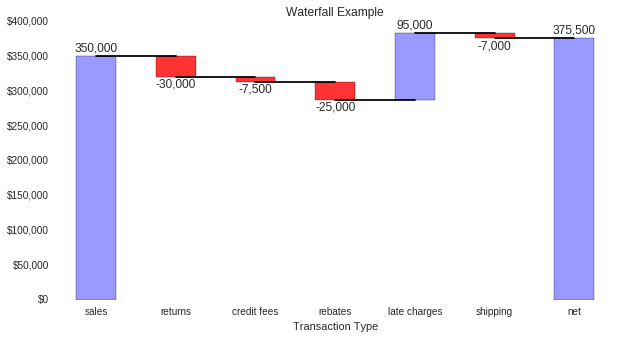

In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
sns.set(style="white")

# Format numbers to currency
def money(x, pos):
    'The two args are the value and tick position'
    return "${:,.0f}".format(x)
formatter = FuncFormatter(money)

# If reading from Excel file
#trans = pd.read_excel(r'D:\path_to_your.xlsx', index_col=0 )
title = 'Waterfall Example'
xaxis_label = 'Transaction Type'
yaxis_label = ''

# Data to plot. Do not include a total, it will be calculated
index = ['sales','returns','credit fees','rebates','late charges','shipping']
data = {'amount': [350000,-30000,-7500,-25000,95000,-7000]}

# Store data and create a blank series to use for the waterfall
trans = pd.DataFrame(data=data,index=index)
blank = trans.amount.cumsum().shift(1).fillna(0)

# Assign color to bars: if value is negative, make color of bar red, otherwise, blue
# colors can be color name, RGB (normalized to 0 to 1, so divide by 2255), or hex
colors = []
for value in trans.values:
    if value < 0:
        colors.append((1, 0.2, 0.2)) # RGB(255,51,51) but divide each by 255, so it becomes (1,0.2,0.2)
    else:
        colors.append((0.6,0.6,1))   # RGB(153,153,255)

# Get the net total number for the final element in the waterfall
total = trans.sum().amount
trans.loc["net"] = total
blank.loc["net"] = total

# The steps graphically show the levels as well as used for label placement
step = blank.reset_index(drop=True).repeat(3).shift(-1)
step[1::3] = np.nan

# When plotting the last element, we want to show the full bar,
# Set the blank to 0
blank.loc["net"] = 0

# Plot and label
my_plot = trans.plot(kind='bar', stacked=True, bottom=blank,legend=None, figsize=(10, 5),
                     title=title, color=colors)
my_plot.plot(step.index, step.values,'k')
my_plot.set_xlabel(xaxis_label)
my_plot.set_ylabel(yaxis_label)

# Format the axis for dollars
my_plot.yaxis.set_major_formatter(formatter)

# Get the y-axis position for the labels
y_height = trans.amount.cumsum().shift(1).fillna(0)

# Get an offset so labels don't sit right on top of the bar
max = trans.max()
neg_offset = max / 25
pos_offset = max / 50
plot_offset = int(max / 15)

# Start label loop
loop = 0
for index, row in trans.iterrows():
    # For the last item in the list, we don't want to double count
    if row['amount'] == total:
        y = y_height[loop]
    else:
        y = y_height[loop] + row['amount']
    # Determine if we want a neg or pos offset
    if row['amount'] > 0:
        y += pos_offset
    else:
        y -= neg_offset
    my_plot.annotate("{:,.0f}".format(row['amount']),(loop,y),ha="center")
    loop+=1

# Scale up the y axis so there is room for the labels
my_plot.set_ylim(0, trans.max().values + int(plot_offset))
# Rotate the labels
my_plot.set_xticklabels(trans.index,rotation=0)
# my_plot.get_figure().savefig("waterfall.png",dpi=200,bbox_inches='tight')

sns.despine(bottom=True, left=True)
plt.show()